In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning import *

# Setup
---

## Load data


In [24]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

* ## Training set

In [25]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-01-31 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


* ## Validation set 

In [26]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-02-01 00:00:00':'2024-02-29 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


* ## Test set 

In [27]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-03-01 00:00:00':'2024-03-31 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [28]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-03-03 00:05:00,0.6708,0.6800
2024-03-03 00:10:00,0.6697,0.6798
2024-03-03 00:15:00,0.6712,0.6824
2024-03-03 00:20:00,0.6689,0.6815
2024-03-03 00:25:00,0.6687,0.6816
...,...,...
2024-03-31 23:35:00,0.6695,0.7015
2024-03-31 23:40:00,0.6697,0.7017
2024-03-31 23:45:00,0.6689,0.7008


# Train agent
---

In [29]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(0.5, 2.5), (1.0, 3.0), (1.5, 4.0), (2.0, 4.5), (2.5, 5.0), (3.0, 5.5)]
# Training parameters
F, T = 100, 50 #Formation is the last 16 hours and trading is the next 8 hours
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history = train_dqn(zscore_series_train, 
                                                                   prices_train, 
                                                                   beta_series_train,
                                                                   zscore_series_val,
                                                                   prices_val,
                                                                   beta_series_val,
                                                                   initial_capital,
                                                                   tx_cost,
                                                                   entry_stop_pairs, 
                                                                   F, 
                                                                   T, 
                                                                   num_epochs=600,
                                                                   batch_size=32,
                                                                   gamma = 0.99,
                                                                   lr = 0.001,
                                                                   epsilon_start = 1,
                                                                   epsilon_end = 0.01,
                                                                   epsilon_decay = 0.995,
                                                                   replay_capacity = 1000,
                                                                   target_update_freq = 10,
                                                                   hidden_dim = 64,                                           
                                                                    )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Epoch 01 | AvgReward: 0.00 | Epsilon: 0.995
Epoch 02 | AvgReward: 98.73 | Epsilon: 0.990
Epoch 03 | AvgReward: 70.06 | Epsilon: 0.985
Epoch 04 | AvgReward: 73.25 | Epsilon: 0.980
Epoch 05 | AvgReward: 63.69 | Epsilon: 0.975
Epoch 06 | AvgReward: 92.36 | Epsilon: 0.970
Epoch 07 | AvgReward: 38.22 | Epsilon: 0.966
Epoch 08 | AvgReward: 47.77 | Epsilon: 0.961
Epoch 09 | AvgReward: -25.48 | Epsilon: 0.956
Epoch 10 | AvgReward: 6.37 | Epsilon: 0.951
Epoch 11 | AvgReward: 41.40 | Epsilon: 0.946
Epoch 12 | AvgReward: 73.25 | Epsilon: 0.942
Epoch 13 | AvgReward: 105.10 | Epsilon: 0.937
Epoch 14 | AvgReward: 66.88 | Epsilon: 0.932
Epoch 15 | AvgReward: 133.76 | Epsilon: 0.928
Epoch 16 | AvgReward: 35.03 | Epsilon: 0.923
Epoch 17 | AvgReward: 152.87 | Epsilon: 0.918
Epoch 18 | AvgReward: 28.66 | Epsilon: 0.914
Epoch 19 | AvgReward: 159.24 | Epsilon: 0.909
Epoch 20 | AvgReward: 70.06 | Epsilon: 0.905
Epoch 21 | AvgReward: 19.11 | Epsilon: 0.900
Epoch 22 | AvgReward: -22.29 |

# Training performance
---

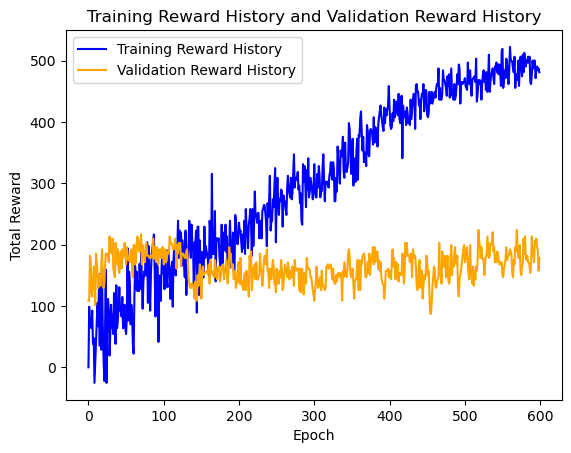

In [30]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

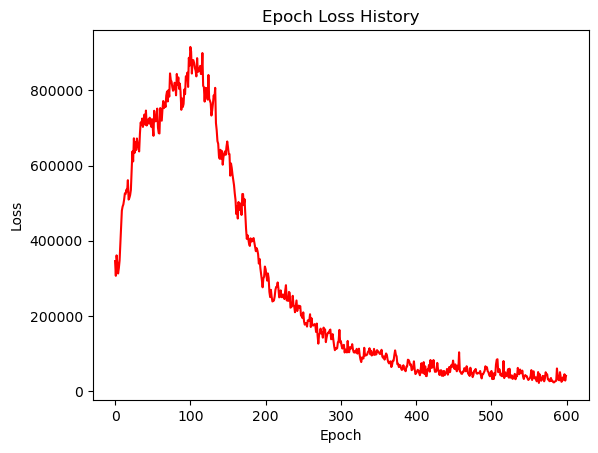

In [31]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Why the “sawtooth” spikes in the loss plot?

Those spikes are normal for two reasons:

    Variable number of updates per epoch: early on, you quickly fill the replay buffer and do many minibatch updates; later epochs may have fewer new transitions, so the average loss per epoch can jump around.

    Target-network syncs: whenever you copy the online net into the target net (every few epochs), you briefly raise the bootstrap targets, which can cause a transient bump in TD‐error before it falls again.

In [32]:
# smoothed = pd.Series(epoch_loss_history).rolling(10, min_periods=1).mean()
# plt.plot(smoothed, color = 'red')
# plt.title('Smoothed Epoch Loss History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

# Test agent 
---

In [33]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=F, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_37344/3959656230.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_net_trained.load_state_dict(torch.load

<All keys matched successfully>

* ## Check performance on training set (just to see if logic is correct)

In [34]:


# # test_rewards,trade_profits,actions,metrics = evaluate_dqn(
# #     online_net_trained,
# #     zscore_series_test,
# #     prices_test,
# #     beta_series_test,
# #     initial_capital,
# #     tx_cost,
# #     entry_stop_pairs,
# #     F, T
# # )
# # print(metrics)

# tx_cost = 0.0

# test_rewards,trade_profits,actions,episodes,metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
#     F, T
# )
# print(metrics)

* ## Check performance on test set 

In [35]:
tx_cost = 0.0

test_rewards,trade_profits,actions,episodes,metrics = evaluate_dqn(
    online_net_trained,
    zscore_series_test,
    prices_test,
    beta_series_test,
    initial_capital,
    tx_cost,
    entry_stop_pairs,
    F, T
)
print(metrics)

{'avg_reward': 259.1463414634146, 'win_rate': 0.43902439024390244, 'loss_rate': 0.07317073170731707, 'forced_rate': 0.21341463414634146, 'no_trade_rate': 0.27439024390243905}


In [36]:
zipper = zip(test_rewards,trade_profits)
for i, (reward, profit,) in enumerate(zipper):
    print(f"Reward: {reward}, Trade Profit: {profit}")

Reward: 1000.0, Trade Profit: [26.538027387560195]
Reward: -500.0, Trade Profit: [38.080925867348284]
Reward: 0.0, Trade Profit: 0.0
Reward: 1000.0, Trade Profit: [39.1946180650991]
Reward: -500.0, Trade Profit: [-18.254798838176555]
Reward: 1000.0, Trade Profit: [22.092147836151597]
Reward: -1000.0, Trade Profit: [-10.910254463096795]
Reward: 0.0, Trade Profit: 0.0
Reward: 1000.0, Trade Profit: [52.80976582595247]
Reward: 0.0, Trade Profit: 0.0
Reward: -500.0, Trade Profit: [29.684199137439926]
Reward: 1000.0, Trade Profit: [55.05218894447345]
Reward: 1000.0, Trade Profit: [-1.629772751730492]
Reward: 0.0, Trade Profit: 0.0
Reward: 1000.0, Trade Profit: [-83.45029092727782]
Reward: 0.0, Trade Profit: 0.0
Reward: 1000.0, Trade Profit: [29.070554808718864]
Reward: -1000.0, Trade Profit: [-33.40744075559274]
Reward: 0.0, Trade Profit: 0.0
Reward: 0.0, Trade Profit: 0.0
Reward: 1000.0, Trade Profit: [49.331521738146975]
Reward: 1000.0, Trade Profit: [38.28276260939613]
Reward: 1000.0, Tra

In [37]:
#Get trade profits greater than 0
trade_profits = [trade_profit for trade_profit in trade_profits if trade_profit != 0]

In [38]:
len(trade_profits)

119

Episode {'trade_start': Timestamp('2024-03-03 08:30:00'), 'trade_end': Timestamp('2024-03-03 12:35:00'), 'trade_entry_metadata': {'time': Timestamp('2024-03-03 08:35:00'), 'S1': 0.6346, 'S2': 0.6524, 'z': -1.500280236573799, 'position': 1}, 'entry': 1.0, 'stop': 3.0}:


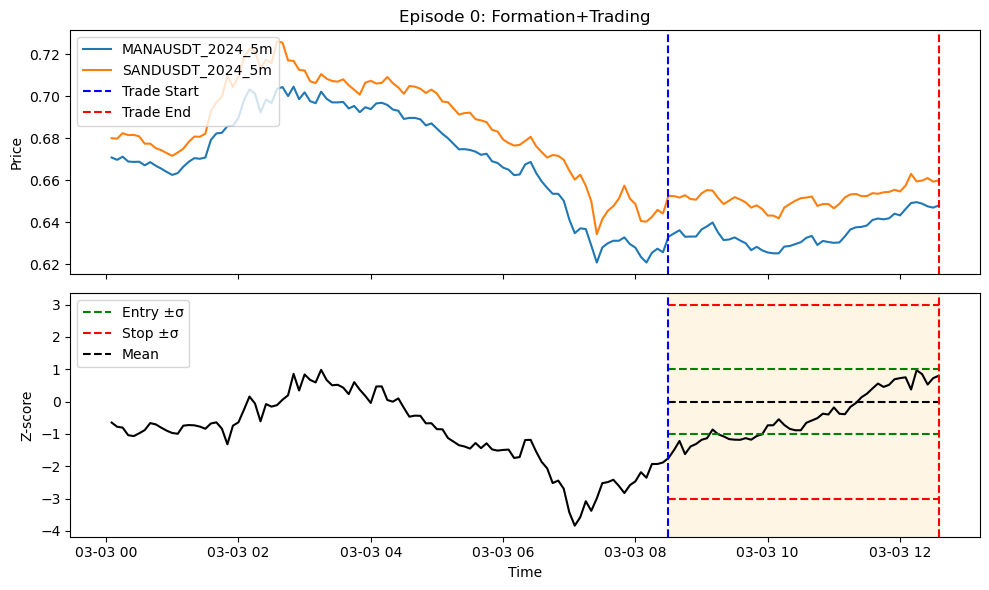

In [39]:
plot_episodes(prices_test, zscore_series_test, episodes, F, T, episode_idx=0)


Percentage_Return:  12.08565247238697 %


Text(0, 0.5, 'Cumulative Profit')

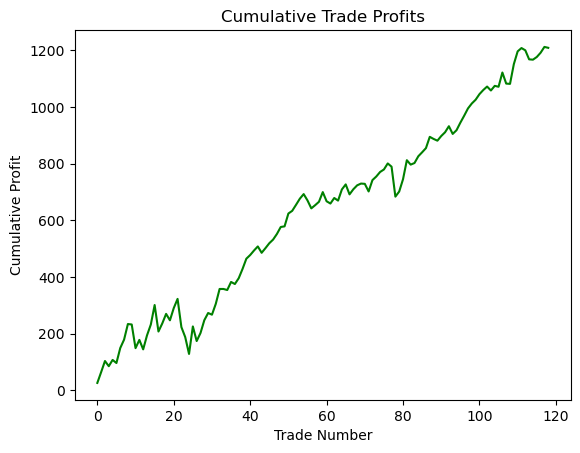

In [40]:
trade_profits_cumulative = np.cumsum(trade_profits)
plt.plot(trade_profits_cumulative, color = 'green')
print("Percentage_Return: ", (trade_profits_cumulative[-1] / initial_capital) * 100,"%")
plt.title('Cumulative Trade Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')


# Check performance with static thresholds
---

In [78]:
# entry_threshold = 1.5
# exit_threshold = 0
# stop_loss_threshold = 3

# positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
# trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

entry_threshold = 1
exit_threshold = 0
stop_loss_threshold = 3

#WITH TRAINING SET
#-----------------------

# positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
# trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

#WITH TEST SET
#-----------------------

positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

In [79]:
len(trade_profits_no_agent)

142

Percentage_Return:  12.521747387654294 %


/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_37344/3214939763.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


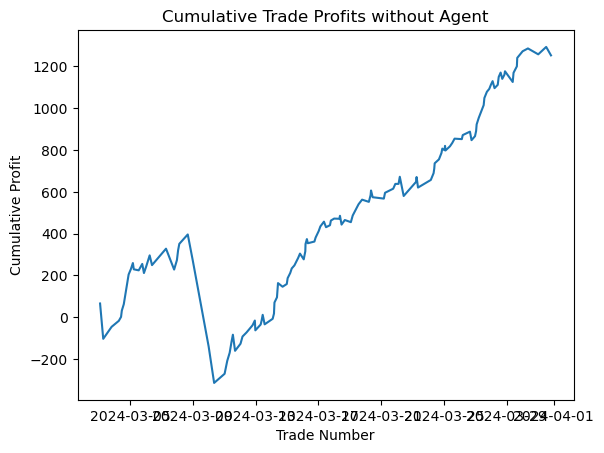

In [80]:
plt.plot(cumulative_profit_series_no_agent)
print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
plt.title('Cumulative Trade Profits without Agent')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()

In [81]:
trade_durations_minutes = [(exit_time - entry_time).total_seconds() / 60 for entry_time, exit_time in zip(entry_times_no_agent, exit_times_no_agent)]
np.mean(trade_durations_minutes)

147.5

In [44]:
cumulative_profit_series_no_agent

2024-03-03 11:25:00   -116.462695
2024-03-03 19:50:00    -36.209637
2024-03-04 06:50:00     27.636090
2024-03-04 10:15:00     55.367870
2024-03-04 14:25:00    101.913014
                          ...    
2024-03-29 09:10:00    752.333319
2024-03-29 15:30:00    806.445093
2024-03-30 08:25:00    831.383757
2024-03-31 00:10:00    816.512996
2024-03-31 23:55:00    774.039301
Length: 77, dtype: float64